Original distribution: [0.2443  0.24318 0.25928 0.25324]
New distribution: [0.27221 0.27252 0.21648 0.23879]
Original transition frequencies:
[[0.22020221 0.02409024 0.         0.        ]
 [0.02409024 0.21651216 0.00258003 0.        ]
 [0.         0.00258003 0.25426254 0.00244002]
 [0.         0.         0.00244002 0.25080252]]
New transition frequencies:
[[0.24490245 0.02731027 0.         0.        ]
 [0.02731027 0.24283242 0.00238002 0.        ]
 [0.         0.00238002 0.21169211 0.00240002]
 [0.         0.         0.00241002 0.23638237]]
Kolmogorov-Smirnov test: statistic = 0.05725000000000002, p-value = 6.894193518534046e-143


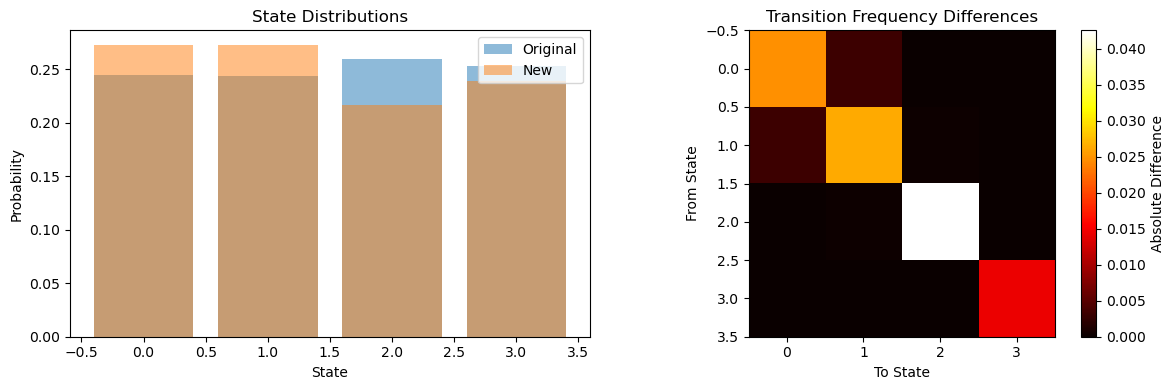

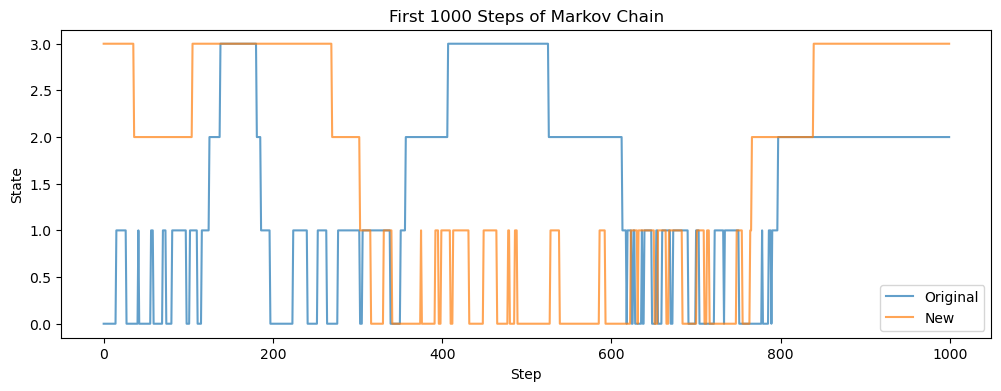

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

tf.config.run_functions_eagerly(True)

@tf.function
def original_markov_chain(params, num_steps):
    kc12, kc21, _, _, _, _, _, kco1, koc2, ko12, ko21 = params
    
    transition_matrix = tf.stack([
        [1-kc12, kc12, 0, 0],
        [kc21, 1-kc21-kco1, kco1, 0],
        [0, koc2, 1-koc2-ko12, ko12],
        [0, 0, ko21, 1-ko21]
    ])
    
    initial_distribution = tfp.distributions.Categorical(probs=[0.3, 0.3, 0.2, 0.2])
    
    markov_chain = tfp.distributions.MarkovChain(
        initial_state_prior=initial_distribution,
        transition_fn=lambda _, state: tfp.distributions.Categorical(probs=tf.gather(transition_matrix, state)),
        num_steps=num_steps
    )

    return markov_chain.sample()

@tf.function
def new_markov_chain(params, num_steps):
    kc12, kc21, _, _, _, _, _, kco1, koc2, ko12, ko21 = params
    
    transition_matrix = tf.stack([
        [1-kc12, kc12, 0, 0],
        [kc21, 1-kc21-kco1, kco1, 0],
        [0, koc2, 1-koc2-ko12, ko12],
        [0, 0, ko21, 1-ko21]
    ])
    
    initial_probs = tf.constant([0.3, 0.3, 0.2, 0.2])
    
    def body(i, state, states):
        next_state_probs = tf.gather(transition_matrix, state)
        next_state = tf.cast(tf.random.categorical(tf.math.log([next_state_probs]), num_samples=1)[0, 0], tf.int32)
        states = states.write(i, next_state)
        return i+1, next_state, states

    initial_state = tf.cast(tf.random.categorical(tf.math.log([initial_probs]), num_samples=1)[0, 0], tf.int32)
    states = tf.TensorArray(tf.int32, size=num_steps)
    _, _, states = tf.while_loop(
        lambda i, *_: i < num_steps,
        body,
        (tf.constant(0, dtype=tf.int32), initial_state, states)
    )
    
    return states.stack()

@tf.function
def get_transition_freqs(states):
    transitions = tf.stack([states[:-1], states[1:]], axis=1)
    return tf.math.bincount(transitions[:, 0] * 4 + transitions[:, 1], minlength=16, dtype=tf.float32) / tf.cast(tf.shape(states)[0] - 1, tf.float32)

# Set up parameters
num_samples = 10000
num_steps = 100000
params = tf.constant([0.1, 0.1, 0, 0, 0, 0, 0, 0.01, 0.01, 0.01, 0.01], dtype=tf.float32)

# Run simulations
original_output = original_markov_chain(params, num_steps)
new_output = new_markov_chain(params, num_steps)

# Compare state distributions
original_dist = tf.reduce_mean(tf.one_hot(original_output, depth=4), axis=0)
new_dist = tf.reduce_mean(tf.one_hot(new_output, depth=4), axis=0)

print("Original distribution:", original_dist.numpy())
print("New distribution:", new_dist.numpy())

# Compare transition frequencies
original_trans_freqs = get_transition_freqs(original_output).numpy().reshape(4, 4)
new_trans_freqs = get_transition_freqs(new_output).numpy().reshape(4, 4)

print("Original transition frequencies:")
print(original_trans_freqs)
print("New transition frequencies:")
print(new_trans_freqs)

# Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(original_output.numpy(), new_output.numpy())
print(f"Kolmogorov-Smirnov test: statistic = {ks_statistic}, p-value = {p_value}")

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.bar(range(4), original_dist.numpy(), alpha=0.5, label='Original')
plt.bar(range(4), new_dist.numpy(), alpha=0.5, label='New')
plt.title('State Distributions')
plt.xlabel('State')
plt.ylabel('Probability')
plt.legend()

plt.subplot(122)
plt.imshow(np.abs(original_trans_freqs - new_trans_freqs), cmap='hot', interpolation='nearest')
plt.colorbar(label='Absolute Difference')
plt.title('Transition Frequency Differences')
plt.xlabel('To State')
plt.ylabel('From State')

plt.tight_layout()
plt.show()

# Time series plot
plt.figure(figsize=(12, 4))
plt.plot(original_output.numpy()[:1000], label='Original', alpha=0.7)
plt.plot(new_output.numpy()[:1000], label='New', alpha=0.7)
plt.title('First 1000 Steps of Markov Chain')
plt.xlabel('Step')
plt.ylabel('State')
plt.legend()
plt.show()